<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/Amazon_Food_Reviews_Sentiment_Analysis/Amazon_Fine_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Amazon Food Reviews Analysis </h1>

# 1. Overview

## 1.1 Data Overview

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

<b>Attribute Information: </b>


<table>
  <tr>
    <th>Attribute Name</th>
    <th>Information</th>
  </tr>
  <tr>
    <td>Id </td>
  </tr>
  <tr>
    <td>ProductId</td>
    <td>Unique identifier for the product</td>
  </tr> 
  <tr>
    <td>UserId</td> 
    <td>Unqiue identifier for the user</td>
  </tr>
  <tr>
    <td>ProfileName</td>
    <td></td>
  </tr>
  <tr>
    <td>HelpfulnessNumerator</td>
    <td>Number of users who found the 
    review helpful</td>
  </tr>
  <tr>
    <td>HelpfulnessDenominator</td>
    <td>Number of users who indicated whether they found the review helpful or not</td>
  </tr>
  <tr>
    <td>Score</td>
    <td>Rating between 1 and 5</td>
  </tr>
  <tr>
    <td>Time</td>
    <td>Timestamp for the review</td>
  </tr>
  <tr>
    <td>Summary</td>
    <td>Brief summary of the review</td>
  </tr>
  <tr>
    <td>Text</td>
    <td>Text of the review</td>
  </tr>
</table>


## 1.2 Real World / Business Objectives and Constraints


*  Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

# 2. Machine Learning Problem

## 2.1 Mapping the real-world problem to a Machine Learning Problem

### 2.1.1 Type of Machine Learning Problem

<p> It is a binary classification problem</p>

*  Given a review, we are going to predict whether it is a positive review or a negative review.



### 2.1.2 Performance metric

<b>F1-Score (F-Score or F-measure): </b> <br>
*  The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

```
F1 = 2 * (precision * recall) / (precision + recall)
```


<br>
<b> ROC AUC Score: </b><br>

*  Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
*  A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

<br>
<b>Source:</b> <br>

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# 3. Exploratory Data Analysis

In [0]:
import re
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

try:
  STOPWORDS = set(stopwords.words())
except:  
  nltk.download('stopwords')
  STOPWORDS = set(stopwords.words())

STOPWORDS.remove('not')

DATA_DIR = 'drive/My Drive/ML Projects/Amazon Fine Food Reviews/data'
INPUT_DIR = DATA_DIR + '/input/'
pd.set_option('display.max_columns', 10)

In [0]:
# Create a database connection instance
con = sqlite3.connect(INPUT_DIR + 'amazon_food_reviews_database.sqlite')

In [0]:
df = pd.read_sql('SELECT * FROM reviews WHERE 1', con=con)

## 2.1 High Level Statistics

<b> What is the dimension of our dataset? </b>

In [186]:
print('Total number of rows: {}'.format(df.shape[0]))
print('Total number of columns: {}'.format(df.shape[1]))

Total number of rows: 568454
Total number of columns: 10


In [187]:
df.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
28404,28405,B007OXJMD2,A214A74RTIM7YX,Dori Bruce,0,0,5,1322006400,Great Product!,These are my favorite flavor of K Cups and I r...
360575,360576,B003U7SJQC,AUXT4ZEDE4Z6Z,Mercedes,11,13,1,1305072000,TINY TINY TINY,HEED THE REVIEWS.<br /><br />This thing is TIN...
296728,296729,B00469VMO4,A1CIRCCJFZGGXP,Standing Bear,0,0,5,1338422400,Had this coffee AMAZING!!!,THIS PRODUCT IS AMAZING!<br />Best coffee ever...
524516,524517,B000N142IW,A1VDZNIO5XCAOO,www.TheBestMoms.com,6,6,3,1183852800,They do taste wonderful...,...and they really do curb cravings-but they a...
137793,137794,B000CQE3HS,A2D6Q9PSMNGEEA,SMEng64,0,0,5,1342051200,Fast Mover - Everybody Loves Them!,We purchase these items for our snack cart in ...


In [188]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


<b> Are there Null Values in the dataset? </b>

In [189]:
df.isna().sum() / df.shape[0]

Id                        0.0
ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
dtype: float64

<b> What type of variables do we have? </b>

In [190]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

<b> Do we have duplicate reviews in the dataset? </b>

In [191]:
dup_counts = df[['UserId', 'ProfileName', 'Time', 'Text']].duplicated().sum()
print('Percentage of Duplicate Reviews:', str(round(dup_counts/df.shape[0]*100, 2))+'%')

Percentage of Duplicate Reviews: 30.7%


<b> What is the distribution of the Score variable? </b>

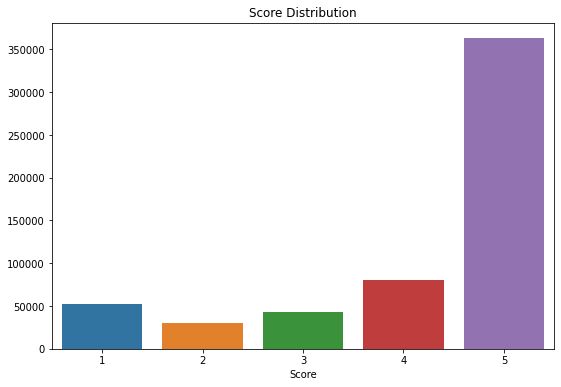

In [192]:
plt.figure(figsize=(9,6))
plt.title('Score Distribution')
sns.barplot(x=df['Score'].value_counts().index, 
            y=df['Score'].value_counts().values)
plt.xlabel('Score')
plt.show()

<b> What is the distribution of Helpfulness? </b>

In [0]:
df['HelpfulPerc'] = (df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']) * 100
df.loc[df['HelpfulPerc'].isna(), 'HelpfulPerc'] = -1

In [0]:
def map_helpfulness(value):
  if value == -1:
    return 'No Indication'
  elif value >= 75:
    return '> 75%'
  elif value > 25 and value < 75:
    return '25 - 75%'
  elif value > -1 and value <= 25:
    return '< 25%'

In [0]:
df['HelpfulPerc_Indicator'] = df['HelpfulPerc'].apply(map_helpfulness)

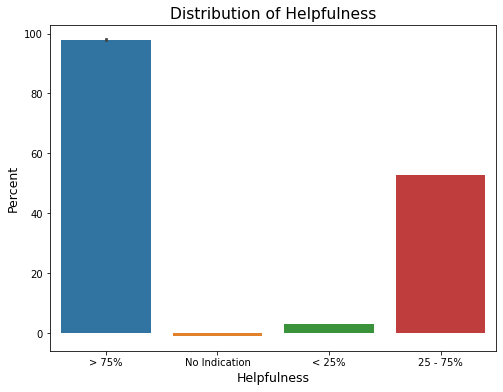

In [211]:
plt.figure(figsize=(8, 6))
plt.title('Distribution of Helpfulness', fontsize=15.5)
sns.barplot(x='HelpfulPerc_Indicator', y='HelpfulPerc', data=df)
plt.ylabel('Percent', fontsize=12.5)
plt.xlabel('Helpfulness', fontsize=12.5)
plt.show()

<b> What is the distribution of Helpfulness w.r.t Score? </b>

In [0]:
def helpful_indicator(x): 
  if x < 25 and x > -1:
    return 'Not Helpful'
  elif x >= 75:
    return 'Helpful'

In [0]:
df['Helpful/Unhelpful'] = df['HelpfulPerc'].apply(helpful_indicator)

In [0]:
helpfulness_dist = df.groupby(['Score', 'Helpful/Unhelpful']).count()['Id'].reset_index()
helpfulness_dist['Perc'] = helpfulness_dist['Id'] / helpfulness_dist['Id'].sum()

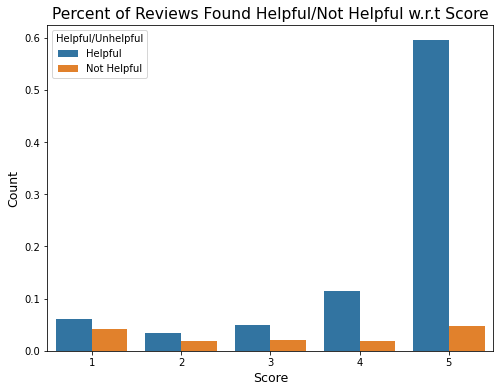

In [215]:
plt.figure(figsize=(8, 6))
plt.title('Percent of Reviews Found Helpful/Not Helpful w.r.t Score', fontsize=15.5)
sns.barplot(x='Score', y='Perc', data=helpfulness_dist, hue='Helpful/Unhelpful')
plt.ylabel('Count', fontsize=12.5)
plt.xlabel('Score', fontsize=12.5)
plt.show()

<b> Observation(s): </b>

*  There are 568,454 datapoints and 69.3% of them are unique.
*  We have 5 categorical variables and 5 numerical variables
*  There are no null values in the dataset.
*  The target variable is skewed. This implies that our dataset is suffering from class imbalance issue

## 2.2 Basic Data Preprocessing

The dataset is pretty much clean, however, we still need to perform the following:

1. Data Deduplication

2. Remove unnecessary columns

3. Converting the target variable into a binary categorical variable

Here, I will remove the columns: Id, UserId, ProfileName, & Time

In [0]:
# Deduplication
primary_columns = ['UserId', 'ProfileName', 'Time', 'Text']
columns_of_int = ['ProductId', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
                  'Time', 'Summary', 'Text', 'Score']
df = df[~df[primary_columns].duplicated()]

# Remove unnecessary columns
df = df[columns_of_int]

# Binarize target variable
df = df[df['Score'] != 3]
df['Score'] = df['Score'].apply(lambda x: 0 if x in [1,2] else 1)

In [13]:
print('Number of rows after preprocessing:', df.shape[0])
print('Number of columns after preprocessing:', df.shape[1])

Number of rows after preprocessing: 364164
Number of columns after preprocessing: 7


In [14]:
df['Score'].value_counts()

1    307056
0     57108
Name: Score, dtype: int64

## 2.3 Text Preprocessing

In [0]:
def remove_html_tags(string):
  return re.sub('<.+?>', ' ', string).strip()

def remove_url(string):
  return re.sub('http\S+', ' ', string).strip()

def to_lower(string):
  return string.lower()

def remove_special_characters(string):
  return re.sub('[^A-Za-z0-9]+', ' ', string).strip()

def decontracted(string):
    # https://stackoverflow.com/a/47091490/4084039

    # specific
    phrase = re.sub(r"won't", "will not", string)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_words_with_numbers(string):
  return re.sub('\S*\d\S*', '', string).strip()

def remove_stopwords(string):
  return ' '.join([i for i in string.split() if i not in STOPWORDS])

def preprocess_text(string):
  string = to_lower(string)
  string = remove_html_tags(string)
  string = remove_url(string)
  string = remove_special_characters(string)
  string = decontracted(string)
  string = remove_words_with_numbers(string)
  string = remove_stopwords(string)
  return string.strip()

In [16]:
tqdm.pandas()
df['Text'] = df['Text'].progress_apply(preprocess_text)
df['Summary'] = df['Summary'].progress_apply(preprocess_text)

100%|██████████| 364164/364164 [00:06<00:00, 54645.86it/s]


### 2.3.2 Train and Test set splitting

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Text', 'Summary']], df['Score'], 
                                                    stratify=df['Score'], test_size=0.3, random_state=99)

## 2.4 Text Analysis

In [0]:
text_grams = {}
summary_grams = {}
positive_filt = y_train == 1
negative_filt = y_train == 0
pos_text = {}
pos_summary = {}
neg_text = {}
neg_summary = {}

for n in (1, 2):
  # Text
  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[positive_filt, 'Text'])
  text_grams['pos_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[positive_filt, 'Text'])
  pos_text['names_{}'.format(n)] = vectorizer.get_feature_names()
  pos_text['freq_{}'.format(n)]= text_grams['pos_{}_grams'.format(n)].sum(axis=0).A1

  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[negative_filt, 'Text'])
  text_grams['neg_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[negative_filt, 'Text'])
  neg_text['names_{}'.format(n)] = vectorizer.get_feature_names()
  neg_text['freq_{}'.format(n)] = text_grams['neg_{}_grams'.format(n)].sum(axis=0).A1 

  # Summary
  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[positive_filt, 'Summary'])
  summary_grams['pos_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[positive_filt, 'Summary'])
  pos_summary['names_{}'.format(n)] = vectorizer.get_feature_names()
  pos_summary['freq_{}'.format(n)] = summary_grams['pos_{}_grams'.format(n)].sum(axis=0).A1 

  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[negative_filt, 'Summary'])
  summary_grams['neg_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[negative_filt, 'Summary'])
  neg_summary['names_{}'.format(n)] = vectorizer.get_feature_names()
  neg_summary['freq_{}'.format(n)] = summary_grams['neg_{}_grams'.format(n)].sum(axis=0).A1 

In [20]:
print(pos_text.keys())
print(neg_text.keys())
print(pos_summary.keys())
print(neg_summary.keys())

dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])


### 2.4.1 Unigrams

<b> Most Common Positive Words [Text]</b>

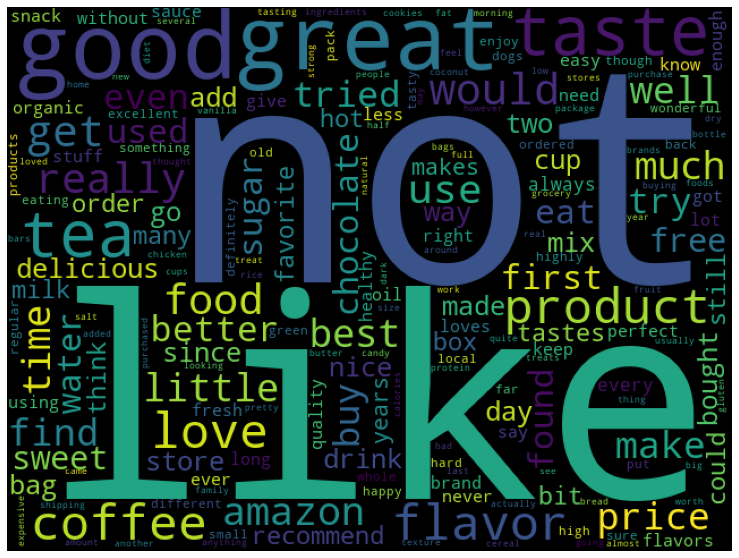

In [21]:
wordcloud = WordCloud(background_color='black', width=640,
                      height=480) \
            .generate_from_frequencies(dict(zip(pos_text['names_1'], pos_text['freq_1'])))
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis(False)
plt.show()

<b> Most Common Positive Words [Summary]</b>

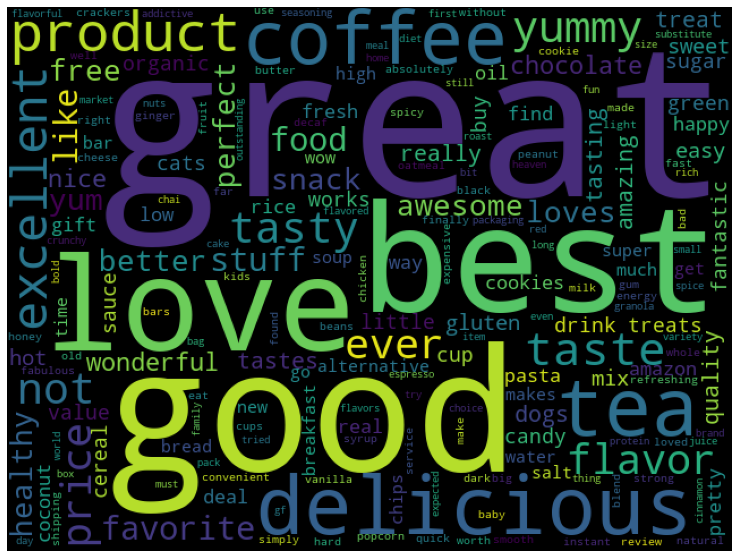

In [22]:
wordcloud = WordCloud(background_color='black', width=640,
                      height=480) \
            .generate_from_frequencies(dict(zip(pos_summary['names_1'], pos_summary['freq_1'])))
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis(False)
plt.show()

<b> Most Common Negative Words [Text]</b>

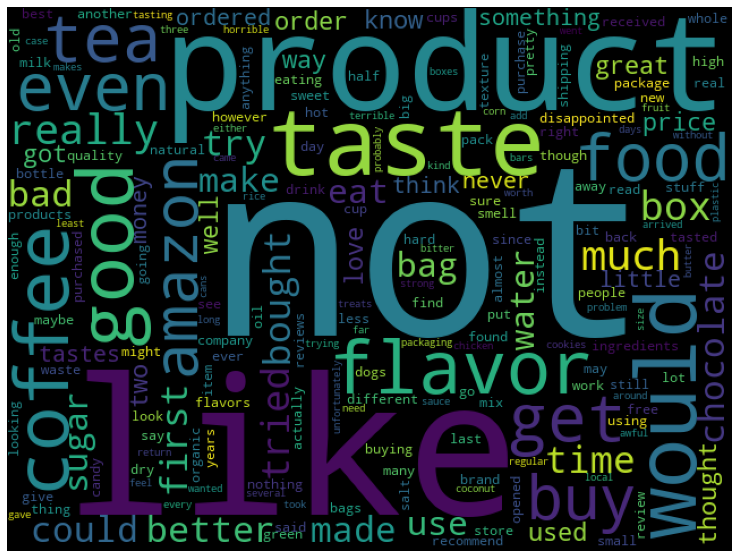

In [23]:
wordcloud = WordCloud(background_color='black', width=640,
                      height=480) \
            .generate_from_frequencies(dict(zip(neg_text['names_1'], neg_text['freq_1'])))
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis(False)
plt.show()

<b> Most Common Negative Words [Summary]</b>

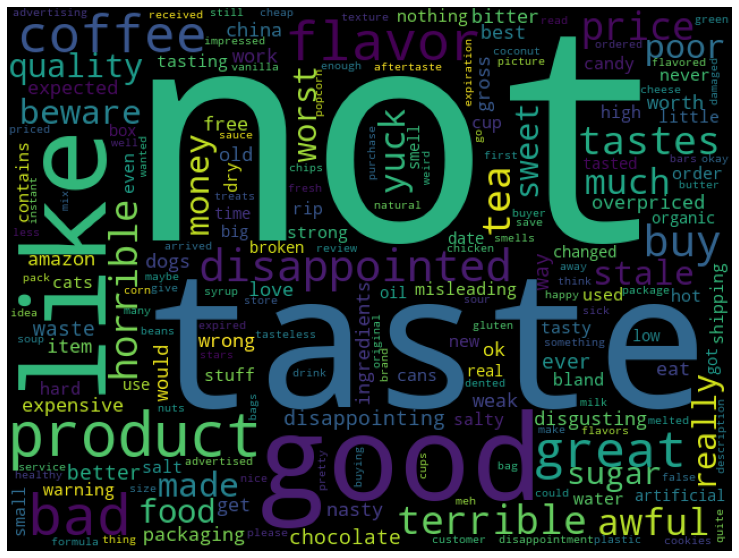

In [24]:
wordcloud = WordCloud(background_color='black', width=640,
                      height=480) \
            .generate_from_frequencies(dict(zip(neg_summary['names_1'], neg_summary['freq_1'])))
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis(False)
plt.show()

### 2.4.2 Bigrams

<b> Most Common Positive Words [Text]</b>

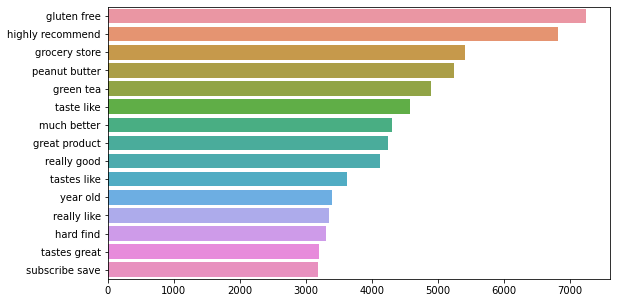

In [25]:
temp_series = pd.Series(dict(zip(pos_text['names_2'], pos_text['freq_2'])))
temp_series = temp_series.sort_values(ascending=False).head(15)
plt.figure(figsize=(9, 5))
sns.barplot(x=temp_series.values, y=temp_series.index)
plt.show()

<b> Most Common Positive Words [Summary]</b>

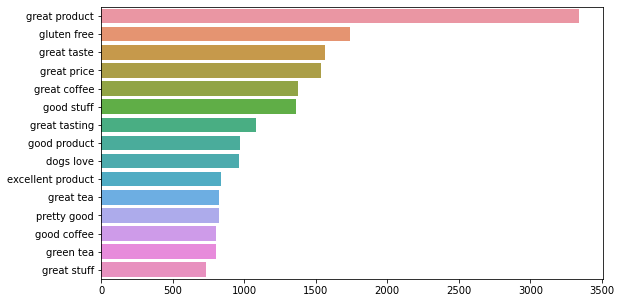

In [26]:
temp_series = pd.Series(dict(zip(pos_summary['names_2'], pos_summary['freq_2'])))
temp_series = temp_series.sort_values(ascending=False).head(15)
plt.figure(figsize=(9, 5))
sns.barplot(x=temp_series.values, y=temp_series.index)
plt.show()

<b> Most Common Negative Words [Text]</b>

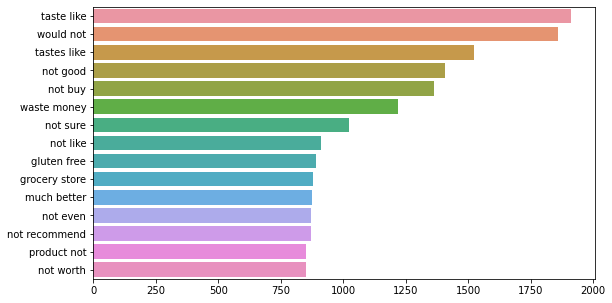

In [27]:
temp_series = pd.Series(dict(zip(neg_text['names_2'], neg_text['freq_2'])))
temp_series = temp_series.sort_values(ascending=False).head(15)
plt.figure(figsize=(9, 5))
sns.barplot(x=temp_series.values, y=temp_series.index)
plt.show()

<b> Most Common Negative Words [Summary]</b>

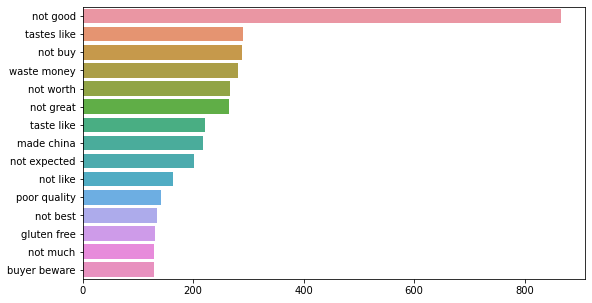

In [28]:
temp_series = pd.Series(dict(zip(neg_summary['names_2'], neg_summary['freq_2'])))
temp_series = temp_series.sort_values(ascending=False).head(15)
plt.figure(figsize=(9, 5))
sns.barplot(x=temp_series.values, y=temp_series.index)
plt.show()

### 2.4.3 Word Count

In [0]:
df['Text_Summary'] = df['Text'] + ' ' + df['Summary']

In [0]:
word_count = df[['Text_Summary', 'Score', 'HelpfulPerc']].copy()
word_count['Count'] = np.log10(word_count['Text_Summary'].apply(lambda x: len([i for i in x.split() if i not in STOPWORDS])))
word_count['Helpful_Indicator'] = word_count['HelpfulPerc'].apply(lambda x: 'Helpful' if x >= 0.75 else 'Not Helpful')

<b> Word Count by Rating </b>

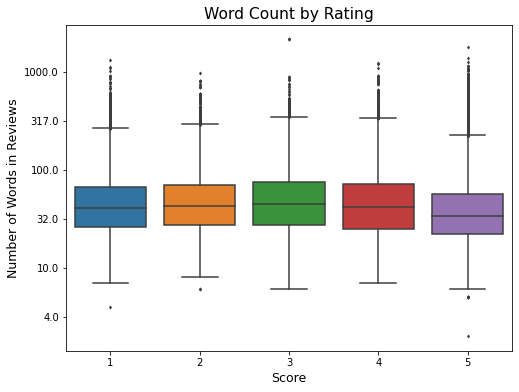

In [133]:
plt.figure(figsize=(8, 6))
plt.title('Word Count by Rating', fontsize=15.5)
sns.boxplot(x='Score', y='Count', data=word_count, fliersize=2)
ticks = [0.5, 1, 1.5, 2, 2.5, 3]
plt.yticks(ticks=ticks, labels=map(str, list(map(lambda x: np.ceil(10**x), ticks))))
plt.ylabel('Number of Words in Reviews', fontsize=12.5)
plt.xlabel('Score', fontsize=12.5)
plt.show()

<b> Word Count by Helpfulness </b>

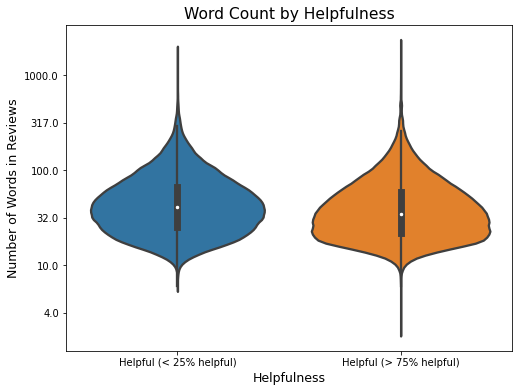

In [145]:
plt.figure(figsize=(8, 6))
plt.title('Word Count by Helpfulness', fontsize=15.5)
sns.violinplot(x='Helpful_Indicator', y='Count', data=word_count, linewidth=2.3)
ticks = [0.5, 1, 1.5, 2, 2.5, 3]
plt.yticks(ticks=ticks, labels=map(str, list(map(lambda x: np.ceil(10**x), ticks))))
plt.ylabel('Number of Words in Reviews', fontsize=12.5)
plt.xlabel('Helpfulness', fontsize=12.5)
plt.xticks([1, 0], ['Helpful (> 75% helpful)', 'Helpful (< 25% helpful)'])
plt.show()